# Activity 5.2. Autoencoder
In this activity we use H2O library to study the behavior of some deep autoencoder networks (For H2O instalation and configuration, please refer to Appendix 5.B). We apply these encouders on the MINST datasets which is a well-known collection of handwritten digits. We also compare their performance for dimension reduction with PCA. In Assignment 3, you will be asked to develop a self-taught network using the autoencoder we study here.

(*Note: Some parts of this activty are borrowed from http://www.r-bloggers.com/a-little-h2o-deeplearning-experiment-on-the-mnist-data-set/ *)

## MINST Dataset
MINST is a large dataset of handwritten digits that can be downloded from: https://www.kaggle.com/c/digit-recognizer/data?train.csv. The train set contatins 42K images each of them of size 28 by 28 pixels. Each row of the `train.csv` file represents one of the vectorized images as well as its label. Tehrefore, the dataset has 785 columns = 1 + 28 X 28. Here, we use a subset of images (only ditigits 0 to 3) that are stored in `train_0_3.csv`.

In [8]:
# read data
data = read.csv('./train.csv')

In [9]:
data <- data[data$label %in% c(0,1,2,3),]

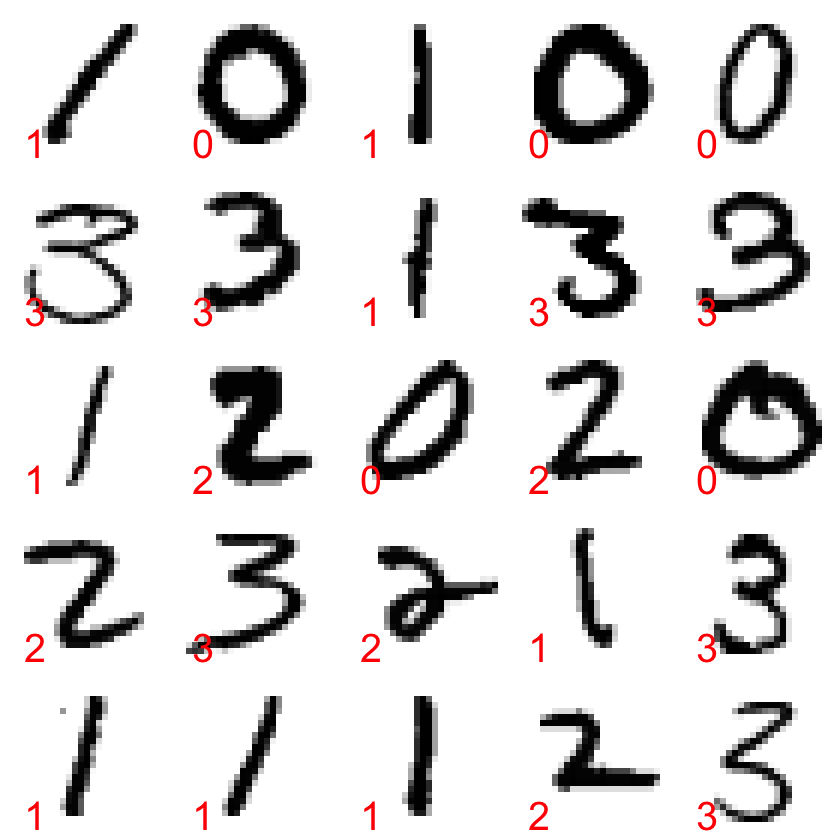

In [3]:
# read data
# data = read.csv('./train_0_3_small.csv')

#visualize some samples
par( mfrow = c(5,5), mai = c(0,0,0,0))
for(i in 1:25){
  y = as.matrix(data[i, 2:785])
  dim(y) = c(28, 28)
  image( y[,nrow(y):1], axes = FALSE, col = gray(255:0 / 255))
  text( 0.2, 0, data[i,1], cex = 3, col = 2, pos = c(3,4))
}
rm(list=ls()) # Clean up unnecessary variables.

## Initialzation
OK! Let's continue with loading H2O library, initiating our local H2O and importing the traininf datasets. 
For more information about these steps, please refer to **Appendix: H2O Library**.

**Note:** If your machine is not powerful enough, you may use `train_0_3_small.csv` instead of `train_0_3.csv` which has only `1000` images. However, this few number of images might not be enough to train a deep autoencoder.

In [12]:
dim(data)

[1] 17344   785

In [13]:
indx <- sample(1:1000, replace = FALSE)
data <- data[indx,]

In [14]:
dim(data)

[1] 1000  785

In [19]:
df <- data

In [20]:
save(df,file="train_0_3_small.csv")

In [18]:
options(warn=-1)
library(h2o)
#If there is a proxy: 
# proxy.old <- Sys.getenv('http_proxy')
# Sys.setenv('http_proxy'='')
localH2O =  h2o.init(nthreads = -1, port = 54321, startH2O = FALSE)

train.file <- '/Users/xiaochengjin/Data_Science/5201_Algorithms/Activity5/train_0_3_small.csv'; # use absolute address or relative to the start location of the H2O instance!
# train.frame <- h2o.importFile(path = train.file,sep=',') 
train.frame <- h2o.importFile(data) 
train.label <- as.character(as.vector(train.frame[,1]))


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: ‘h2o’

The following objects are masked from ‘package:stats’:

    cor, sd, var

The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



ERROR: Error in h2o.init(nthreads = -1, port = 54321, startH2O = FALSE): Cannot connect to H2O server. Please check that H2O is running at http://localhost:54321/


## Autoencoder
From previous chapter, recal that an autoencoder is a neural network that maps input datapoints to lower dimension spaces, then tries to recunstruct them from these low dimensional feature vectors. In this activity, we train three autoencoder with different depths (number of hidden layers). To study their performances, we visualize the feature vectors from the middle hidden layer (which we delibrately choose to have only two units) and compare them with a the first two priciple components that we obtained by running a simple PCA.

To train a deep autoencoder, we call `h2o.deeplearning` function while specifying the number of units in each layer using `hidden` argument. For example, `hidden = c(100, 2, 100)` means we intend to build an autoencoder with three hidden layers where the first and the last one have `100` units and the the middle one has only `2` units. Let's build our three autoencoders.

In [ ]:
options(warn=-1)
NN.model.1 = h2o.deeplearning(    
    x = 2:785, # select all pixels
    training_frame = train.frame, # specify the frame (imported file)    
    hidden = c(100, 2, 100), # number of layers and their units
    epochs = 100, # maximum number of epoches  
    activation = 'Tanh', # activation function 
    autoencoder = TRUE  # is it an autoencoder? Yes!
)
NN.model.2 = h2o.deeplearning(    
    x = 2:785, # select all pixels
    training_frame = train.frame, # specify the frame (imported file)    
    hidden = c(400, 100, 2, 100, 400), # number of layers and their units
    epochs = 100, # maximum number of epoches  
    activation = 'Tanh', # activation function 
    autoencoder = TRUE  # is it an autoencoder? Yes!
)
NN.model.3 = h2o.deeplearning(    
    x = 2:785, # select all pixels
    training_frame = train.frame, # specify the frame (imported file)    
    hidden = c(500,300,100,2,100,300,500), # number of layers and their units
    epochs = 100, # maximum number of epoches  
    activation = 'Tanh', # activation function 
    autoencoder = TRUE  # is it an autoencoder? Yes!
)

Now, our models are built and saved in `NN.model` variables. As mentioned before, we want to visualize the middle hidden layer which for all the model we chose to have only two units. The `h2o.deepfeatures` function helps us to get access to these values. Note that the index of the middle layer varies in each model (as they have different number of layers).

In [ ]:
project.1 = as.matrix(h2o.deepfeatures(NN.model.1, train.frame, layer=2))
project.2 = as.matrix(h2o.deepfeatures(NN.model.2, train.frame, layer=3))
project.3 = as.matrix(h2o.deepfeatures(NN.model.3, train.frame, layer=4))
rm(NN.model.1, NN.model.2, NN.model.3)

OK! Let's calculate the first two principle components and then plot all the projections in one frame.

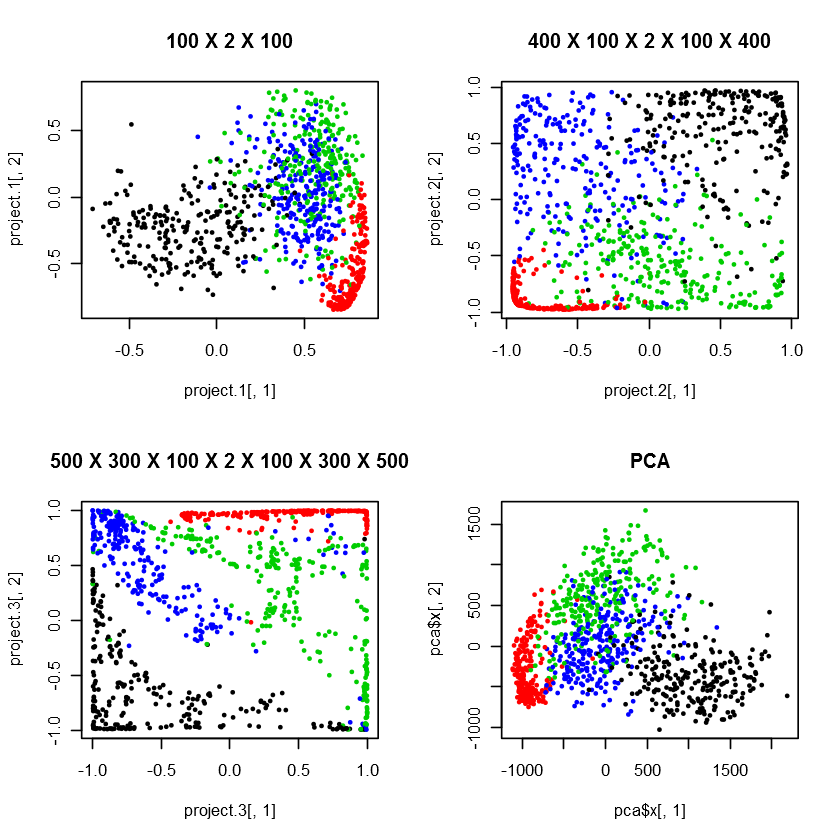

In [10]:
data <- read.csv(train.file)
pca <- prcomp(data[,-1])
par(mfrow=c(2,2))
plot(project.1[,1], project.1[,2], col=data[,1]+1, pch=16, cex=0.5, main='100 X 2 X 100')
plot(project.2[,1], project.2[,2], col=data[,1]+1, pch=16, cex=0.5, main='400 X 100 X 2 X 100 X 400')
plot(project.3[,1], project.3[,2], col=data[,1]+1, pch=16, cex=0.5, main='500 X 300 X 100 X 2 X 100 X 300 X 500')
plot(pca$x[,1], pca$x[,2], col=data[,1]+1, pch=16, cex=0.5, main='PCA')

## Discussions
1- Does increasing the numebr of layers help us creating more discreminative features? 

2- In general, how the number of hidden layers (i.e., the depth of the autoencoder) affects the performance of the network (in terms of recunstruction accuracy and time complexity)?

3- In typical problems, what factors prevent us from building very deep networks (with hundreds of layers)?